In [370]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import catboost
import numpy as np

In [371]:
df = pd.read_csv("../data/raw/train.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

<AxesSubplot: >

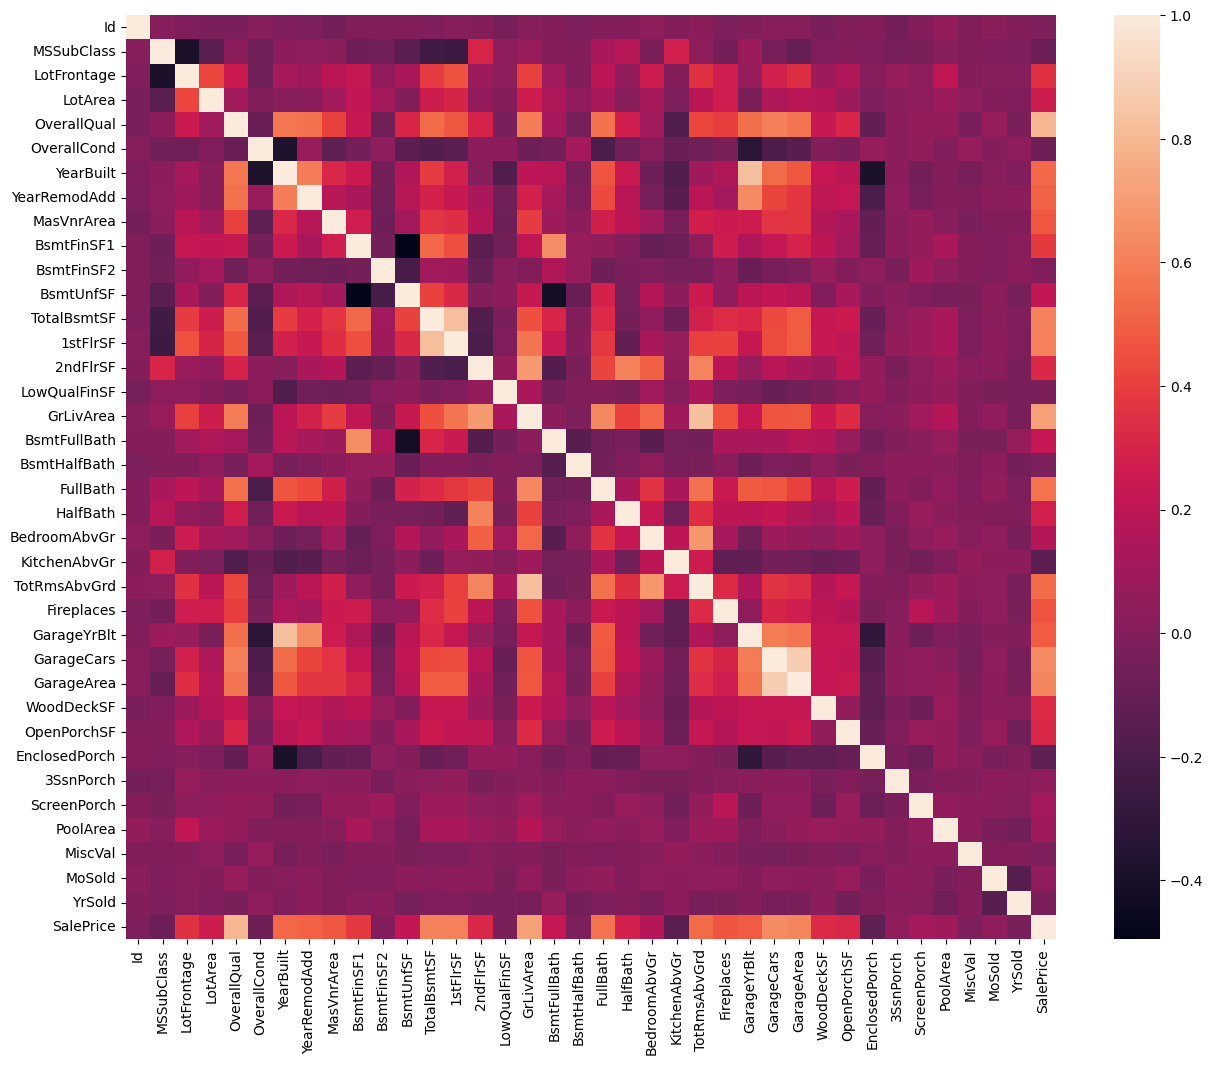

In [372]:
plt.subplots(figsize=(15, 12))
sns.heatmap(df.corr())

In [373]:
df.isna().sum().sort_values(ascending=False)[:20]

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageYrBlt       81
GarageCond        81
GarageType        81
GarageFinish      81
GarageQual        81
BsmtFinType2      38
BsmtExposure      38
BsmtQual          37
BsmtCond          37
BsmtFinType1      37
MasVnrArea         8
MasVnrType         8
Electrical         1
Id                 0
dtype: int64

In [374]:
import pandas as pd
import cmath


def preprocess(df: pd.DataFrame) -> pd.DataFrame:
    df = df.set_index("Id")
    df = df.drop("PoolQC", axis=1)  # not enough samples, can be replaced by PoolArea
    df = df.dropna(subset=["Electrical"])
    df["MasVnrType"] = df["MasVnrType"].replace("None", np.nan) # Might as well treat None and NaN the same
    
    # Not needed anymore
    # df = df.fillna(
    #     {
    #         "Alley": "NA",
    #         "MasVnrType": "None",
    #         "MasVnrArea": 0,
    #         # Basement
    #         "BsmtQual": "NA",
    #         "BsmtCond": "NA",
    #         "BsmtExposure": "NA",
    #         "BsmtFinType1": "NA",
    #         "BsmtFinType2": "NA",
    #         # Fireplace
    #         "FireplaceQu": "NA",
    #         # Garage
    #         "GarageType": "NA",
    #         "GarageYrBlt": 0,
    #         "GarageFinish": "NA",
    #         "GarageCars": 0,
    #         "GarageArea": 0,
    #         "GarageQual": "NA",
    #         "GarageCond": "NA",
    #         "Fence": "NA",
    #         "MiscFeature": "NA",
    #     }
    # )
    df = fill_rest(df)
    return df


def fill_rest(df: pd.DataFrame) -> pd.DataFrame:
    for col in df.columns:
        if df[col].notna().all():
            continue
        if df[col].dtype == "object":
            # mode = df[col].mode()[0]
            # df[col] = df[col].fillna(mode)
            df[col] = df[col].fillna("NA")
        else:
            # mean = df[col].mean()
            # df[col] = df[col].fillna(mean)
            df[col] = df[col].fillna(0)
    return df

In [375]:
df = preprocess(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1459 entries, 1 to 1460
Data columns (total 79 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1459 non-null   int64  
 1   MSZoning       1459 non-null   object 
 2   LotFrontage    1459 non-null   float64
 3   LotArea        1459 non-null   int64  
 4   Street         1459 non-null   object 
 5   Alley          1459 non-null   object 
 6   LotShape       1459 non-null   object 
 7   LandContour    1459 non-null   object 
 8   Utilities      1459 non-null   object 
 9   LotConfig      1459 non-null   object 
 10  LandSlope      1459 non-null   object 
 11  Neighborhood   1459 non-null   object 
 12  Condition1     1459 non-null   object 
 13  Condition2     1459 non-null   object 
 14  BldgType       1459 non-null   object 
 15  HouseStyle     1459 non-null   object 
 16  OverallQual    1459 non-null   int64  
 17  OverallCond    1459 non-null   int64  
 18  YearBuil

In [376]:
def garage_year_built_to_cat(df: pd.DataFrame) -> pd.Series:
    start_years = map(str, range(1900, 2000, 10))
    end_years = map(str, range(1910, 2001, 10))
    garage_labels = (
        ["NA"] + list(map("-".join, zip(start_years, end_years))) + ["2000+"]
    )
    garage_bins = [-1] + list(range(1900, 2001, 10)) + [9999]
    return pd.cut(
        df.GarageYrBlt,
        bins=garage_bins,
        include_lowest=True,
        labels=garage_labels,
    )


# df.GarageYrBlt = garage_year_built_to_cat(df).astype("object")
def concat_garage_cols(df: pd.DataFrame) -> pd.DataFrame:
    garage_cols = [
        "GarageType",
        "GarageYrBlt",
        "GarageFinish",
        "GarageQual",
        "GarageCond",
    ]
    df["GarageComb"] = df[garage_cols].agg(" ".join, axis=1)
    df = df.drop(garage_cols, axis=1)
    return df


def concat_basement_cols(df: pd.DataFrame) -> pd.DataFrame:
    basement_cols = [
        "BsmtQual",
        "BsmtCond",
        "BsmtExposure",
        "BsmtFinType1",
        "BsmtFinType2",
    ]
    df["BsmtComb"] = df[basement_cols].agg(" ".join, axis=1)
    df = df.drop(basement_cols, axis=1)
    return df


In [377]:
from sklearn.model_selection import train_test_split

X = df.drop(["SalePrice"], axis=1)
y = df["SalePrice"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [378]:
from sklearn.compose import ColumnTransformer
from category_encoders import OrdinalEncoder, OneHotEncoder, CatBoostEncoder
from sklearn.preprocessing import StandardScaler

ord_mapping = [
    {
        "col": "LotShape",
        "mapping": {
            "Reg": 3,
            "IR1": 2,
            "IR2": 1,
            "IR3": 0,
        },
    },
    {
        "col": "Utilities",
        "mapping": {
            "AllPub": 3,
            "NoSewr": 2,
            "NoSeWa": 1,
            "ELO": 0,
        },
    },
    {
        "col": "LandSlope",
        "mapping": {
            "Gtl": 0,
            "Mod": 1,
            "Sev": 2,
        },
    },
    {
        "col": "ExterQual",
        "mapping": {
            "Ex": 4,
            "Gd": 3,
            "TA": 2,
            "Fa": 1,
            "Po": 0,
        },
    },
    {
        "col": "ExterCond",
        "mapping": {
            "Ex": 4,
            "Gd": 3,
            "TA": 2,
            "Fa": 1,
            "Po": 0,
        },
    },
    {
        "col": "BsmtQual",
        "mapping": {
            "Ex": 4,
            "Gd": 3,
            "TA": 2,
            "Fa": 1,
            "Po": 0,
            "NA": -1,
        },
    },
    {
        "col": "BsmtCond",
        "mapping": {
            "Ex": 4,
            "Gd": 3,
            "TA": 2,
            "Fa": 1,
            "Po": 0,
            "NA": -1,
        },
    },
    {
        "col": "BsmtExposure",
        "mapping": {
            "Gd": 3,
            "Av": 2,
            "Mn": 1,
            "No": 0,
            "NA": -1,
        },
    },
    {
        "col": "BsmtFinType1",
        "mapping": {
            "GLQ": 5,
            "ALQ": 4,
            "BLQ": 3,
            "Rec": 2,
            "LwQ": 1,
            "Unf": 0,
            "NA": -1,
        },
    },
    {
        "col": "BsmtFinType2",
        "mapping": {
            "GLQ": 5,
            "ALQ": 4,
            "BLQ": 3,
            "Rec": 2,
            "LwQ": 1,
            "Unf": 0,
            "NA": -1,
        },
    },
    {
        "col": "HeatingQC",
        "mapping": {
            "Ex": 4,
            "Gd": 3,
            "TA": 2,
            "Fa": 1,
            "Po": 0,
        },
    },
    {"col": "CentralAir", "mapping": {"Y": 1, "N": 0,}},
    {
        "col": "Electrical",
        "mapping": {
            "SBrkr": 4,
            "FuseA": 3,
            "FuseF": 2,
            "FuseP": 1,
            "Mix": -1,
        },
    },
    {
        "col": "KitchenQual",
        "mapping": {
            "Ex": 4,
            "Gd": 3,
            "TA": 2,
            "Fa": 1,
            "Po": 0,
        },
    },
    {
        "col": "Functional",
        "mapping": {
            "Typ": 7,
            "Min1": 6,
            "Min2": 5,
            "Mod": 4,
            "Maj1": 3,
            "Maj2": 2,
            "Sev": 1,
            "Sal": 0,
        },
    },
    {
        "col": "FireplaceQu",
        "mapping": {
            "Ex": 4,
            "Gd": 3,
            "TA": 2,
            "Fa": 1,
            "Po": 0,
            "NA": -1,
        },
    },
    {
        "col": "GarageFinish",
        "mapping": {
            "Fin": 2,
            "RFn": 1,
            "Unf": 0,
            "NA": -1,
        },
    },
    {
        "col": "GarageQual",
        "mapping": {
            "Ex": 4,
            "Gd": 3,
            "TA": 2,
            "Fa": 1,
            "Po": 0,
            "NA": -1,
        },
    },
    {
        "col": "GarageCond",
        "mapping": {
            "Ex": 4,
            "Gd": 3,
            "TA": 2,
            "Fa": 1,
            "Po": 0,
            "NA": -1,
        },
    },
    {
        "col": "PavedDrive",
        "mapping": {
            "Y": 2,
            "P": 1,
            "N": 0,
        },
    },
    {
        "col": "Fence",
        "mapping": {
            "GdPrv": 3,
            "MnPrv": 2,
            "GdWo": 1,
            "MnWw": 0,
            "NA": -1,
        },
    },
]
ord_features = set(x["col"] for x in ord_mapping)
cat_features = set(X.columns[X.dtypes == "object"]).difference(ord_features)
real_features = set(X.columns).difference((ord_features.union(cat_features)))

col_tr = ColumnTransformer(
    transformers=[
        ("real", StandardScaler(), list(real_features)),
        ("ord", OrdinalEncoder(handle_unknown=-1, mapping=ord_mapping), list(ord_features)),
        ("cat", OneHotEncoder(handle_unknown="value"), list(cat_features)),
    ],
    remainder="passthrough",
)
col_tr.fit(X, y)

ColumnTransformer(remainder='passthrough',
                  transformers=[('real', StandardScaler(),
                                 ['GarageArea', 'YearBuilt', 'TotRmsAbvGrd',
                                  'BsmtHalfBath', 'YrSold', 'FullBath',
                                  'GarageYrBlt', 'LowQualFinSF', 'BsmtUnfSF',
                                  'GrLivArea', 'ScreenPorch', 'OverallQual',
                                  'HalfBath', 'KitchenAbvGr', 'TotalBsmtSF',
                                  'MSSubClass', 'EnclosedPorch', 'OpenPorchSF',
                                  'OverallCond', 'LotArea', 'Bedr...
                                  'FireplaceQu', 'BsmtFinType1', 'LandSlope',
                                  'BsmtQual', 'KitchenQual', 'Functional']),
                                ('cat', OneHotEncoder(),
                                 ['MiscFeature', 'LotConfig', 'Condition2',
                                  'GarageType', 'BldgType', 'SaleCondition',
                                  'RoofStyle', 'Condition1', 'SaleType',
                                  'RoofMatl', 'Neighborhood', 'HouseStyle',
                                  'Exterior2nd', 'MSZoning', 'Alley', 'Street',
                                  'Heating', 'LandContour', 'Exterior1st',
                                  'Foundation', 'MasVnrType'])])

In [379]:
import catboost
from sklearn.model_selection import GridSearchCV

# _cat_features = [df.columns.get_loc(c) for c in df[cat_features]]
# _cat_features = list(X.columns[X.dtypes == "object"])
cb = catboost.CatBoostRegressor(
    random_state=1, iterations=1000, max_depth=4, verbose=0,# cat_features=_cat_features
)
cb.fit(X=col_tr.transform(X_train), y=y_train, plot=True, use_best_model=True)
cb.score(col_tr.transform(X_test), y_test)
# cb.fit(X=X_train, y=y_train, plot=True, use_best_model=True)
# cb.score(X_test, y_test)

# param_grid = {
#     "max_depth": (4, 8, 12),
#     "l2_leaf_reg": (0.1, 1, 10, 100, 1000),
#     "grow_policy": ("SymmetricTree", "Depthwise", "Lossguide")

# }
# gs = GridSearchCV(
#     cb,
#     param_grid,
#     verbose=1,
#     cv=3,
#     refit=True,
# )
# gs.fit(col_tr.transform(X_train), y_train)
# best = gs.best_estimator_
# print(best.score(col_tr.transform(X_test), y_test))
# print(gs.best_params_)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

You should provide test set for use best model. use_best_model parameter has been switched to false value.


0.9317167083811095

In [403]:
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score

pipe = Pipeline(steps=[
    ("col_tr", col_tr),
    ("clf", ExtraTreesRegressor(
        verbose=1,
        random_state=1,
        n_estimators=100,
        n_jobs=-1
    )),
])
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
r2_score(y_test, y_pred)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


0.9164394292148854

In [99]:
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report

pairs = []
for col in y_test.columns:
    col_tr = ColumnTransformer(transformers=[
        ("cat", OneHotEncoder(), cat_features)  
    ])
    col_tr.fit(X) # to fit all features

    pipe = Pipeline(steps=[
        ("col_tr", col_tr),
        ("clf", SGDClassifier(
            verbose=0,
            random_state=1,
            class_weight="balanced",
            loss="log_loss",
            alpha=0.0001
        )),
    ])
    X_train_tr = col_tr.transform(X_train)
    skip_pipe = Pipeline(pipe.steps[-1:])
    skip_pipe.fit(X_train_tr, y_train[col])
    y_pred = pipe.predict(X_test)
    pairs.append((y_test[col], y_pred))
rate_model(pairs)
# print(classification_report(y_test.iloc[:, 1], pipe.predict(X_test)))

(0.2848167539267016,
 [0.47643979057591623,
  0.23036649214659685,
  0.20418848167539266,
  0.2513089005235602,
  0.2617801047120419])

In [373]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'clf__loss': ("modified_huber", "log_loss", "huber", "squared_hinge", "perceptron", "hinge"),
    'clf__penalty': ('l2', 'l1', 'elasticnet'),
    'clf__max_iter': (100, 1000, 10000),
    'clf__power_t': (0.1, 0.5, 0.9),
    'clf__learning_rate': ("constant", "optimal", "invscaling", "adaptive"),
    "clf__eta0": (0.0, 0.5, 1.0, 1.5),
    "clf__alpha": (0.00001, 0.0001, 0.001),
}

gs = GridSearchCV(skip_pipe, param_grid, verbose=0, cv=3)
gs.fit(X_train_tr, y_train.iloc[:, 1])
best = gs.best_estimator_
X_test_tr = col_tr.transform(X_test)
print(gs.best_params_)
print(classification_report(y_test.iloc[:, 1], best.predict(X_test_tr)))

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_stochastic

{'clf__alpha': 0.0001, 'clf__early_stopping': False, 'clf__eta0': 1.5, 'clf__learning_rate': 'constant', 'clf__loss': 'huber', 'clf__max_iter': 100, 'clf__penalty': 'l1', 'clf__power_t': 0.1}
              precision    recall  f1-score   support

           0       1.00      0.07      0.12       180
           1       0.06      1.00      0.12        11

    accuracy                           0.12       191
   macro avg       0.53      0.53      0.12       191
weighted avg       0.95      0.12      0.12       191



/usr/local/lib/python3.10/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan ... 0.63486697 0.63486697 0.63486697]
  warnings.warn(
